In [10]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

  0  = -1.03732  : (0.00028953048586668405, 0.0010843579195475757)
  1  = -1.03743  : (0.0005372602831413039, 0.002012262296930626)
  2  = -1.03744  : (0.001697156698099683, 0.006357297876787961)
  3  = -1.03755  : (0.0060734644941796805, 0.0227614453901162)
  4  = -1.03788  : (0.026933414249746605, 0.10115323773352866)
  5  = -1.03906  : (0.09167623389190961, 0.34720331065846677)
  6  = -1.04134  : (0.4088637502165008, 1.6142219500887611)
  7  = -1.08483  : (1.712804444738869, 7.59576728803922)
  8  = -1.23891  : (7.588289411695767, 46.771135767280974)
  9  = -1.77897  : (5.987582646296362, 165.93016371816995)
 10  = -3.91447  : (321.6888583642185, 2444.991202176811)
-------
itk::simple::TranslationTransform
 TranslationTransform (0xe3d5a00)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 678954
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [321.689, 2444.99]

Optimizer stop condition: GradientDescentLineSearchOpti

JointHistogramMutualInformationImageToImageMetricv4 (0x2790140): No valid points were found during metric evaluation. For image metrics, verify that the images overlap appropriately. For instance, you can align the image centers by translation. For point-set metrics, verify that the fixed points, once transformed into the virtual domain space, actually lie within the virtual domain.

JointHistogramMutualInformationImageToImageMetricv4 (0x2790140): No valid points were found during metric evaluation. For image metrics, verify that the images overlap appropriately. For instance, you can align the image centers by translation. For point-set metrics, verify that the fixed points, once transformed into the virtual domain space, actually lie within the virtual domain.

JointHistogramMutualInformationImageToImageMetricv4 (0x2790140): No valid points were found during metric evaluation. For image metrics, verify that the images overlap appropriately. For instance, you can align the image cente

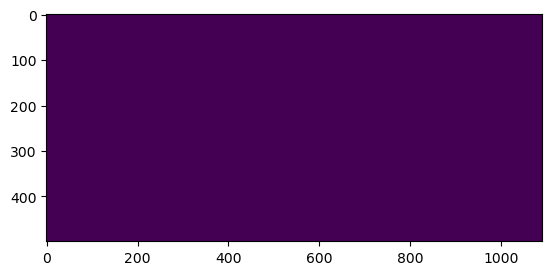

In [50]:

""" A SimpleITK example demonstrating image registration with histogram
    mutual information as a similarity measure. """

import sys
import os
import SimpleITK as sitk


def command_iteration(method):
    """ Callback invoked when the optimization process is running. """
    print(
        f"{method.GetOptimizerIteration():3} "
        + f" = {method.GetMetricValue():7.5f} "
        + f" : {method.GetOptimizerPosition()}"
    )





fixed = sitk.ReadImage(fixed_fp, sitk.sitkFloat32)
fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)

moving = sitk.ReadImage(moving_fp, sitk.sitkFloat32)
moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

R = sitk.ImageRegistrationMethod()

R.SetMetricAsJointHistogramMutualInformation()

R.SetOptimizerAsGradientDescentLineSearch(
    learningRate=1.0,
    numberOfIterations=200,
    convergenceMinimumValue=1e-5,
    convergenceWindowSize=5,
)

R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, out_fp)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)


cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)
nda = sitk.GetArrayFromImage(simg2)
plt.imshow(nda)

Initial Number of Parameters: 50
--------- Resolution Changing ---------
itk::simple::BSplineTransform
 BSplineTransform (0x3b7eca0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 9
   Modified Time: 683786
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0xf341b10, 0xf1230e0 ]
   TransformDomainOrigin: [3, 3]
   TransformDomainPhysicalDimensions: [1090, 498]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [2, 2]
   GridSize: [5, 5]
   GridOrigin: [-542, -246]
   GridSpacing: [545, 249]
   GridDirection: 1 0
0 1


  0 =   -0.86158
  1 =   -0.86217
  2 =   -0.86193
  3 =   -0.86189
  4 =   -0.86253
  5 =   -0.94770
  6 =   -0.94807
  7 =   -0.94738
  8 =   -0.94693
Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 9.
 Iteration: 9
 Metric value: -0.9480699254920726
--------- Resolution Changing ---------
itk::simple::BSplineTransform
 BSplineTransf

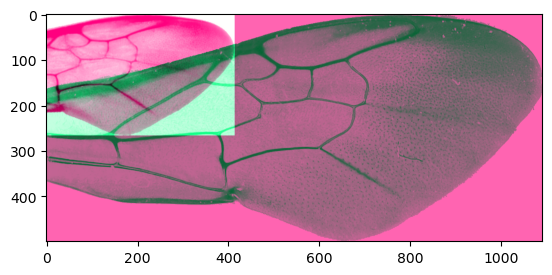

In [51]:

def command_iteration(method, bspline_transform):
    """ Callback invoked each iteration """
    if method.GetOptimizerIteration() == 0:
        # The BSpline is resized before the first optimizer
        # iteration is completed per level. Print the transform object
        # to show the adapted BSpline transform.
        print(bspline_transform)

    print(f"{method.GetOptimizerIteration():3} " + f"= {method.GetMetricValue():10.5f}")


def command_multi_iteration(method):
    """ Callback invoked before starting a multi-resolution level.
    The sitkMultiResolutionIterationEvent occurs before the
    resolution of the transform. This event is used here to print
    the status of the optimizer from the previous registration level.
    """
    if method.GetCurrentLevel() > 0:
        print(
            "Optimizer stop condition: " + f"{R.GetOptimizerStopConditionDescription()}"
        )
        print(f" Iteration: {R.GetOptimizerIteration()}")
        print(f" Metric value: {R.GetMetricValue()}")

    print("--------- Resolution Changing ---------")

fixed_fp = '../2_live_bees/2_card_segs_cropped_and_flipped/2024_06_06_h03bee21_right.png'
moving_fp = '../2_live_bees/type_seg_crop_Hive01_Sheet_01_slide17_left.png'
out_fp = 'test.hdf5'

fixed = sitk.ReadImage(fixed_fp, sitk.sitkFloat32)

moving = sitk.ReadImage(moving_fp, sitk.sitkFloat32)

transformDomainMeshSize = [2] * fixed.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed, transformDomainMeshSize)

print(f"Initial Number of Parameters: {tx.GetNumberOfParameters()}")

R = sitk.ImageRegistrationMethod()
R.SetMetricAsJointHistogramMutualInformation()

R.SetOptimizerAsGradientDescentLineSearch(
    5.0, 100, convergenceMinimumValue=1e-4, convergenceWindowSize=5
)

R.SetInterpolator(sitk.sitkLinear)

R.SetInitialTransformAsBSpline(tx, inPlace=True, scaleFactors=[1, 2, 5])
R.SetShrinkFactorsPerLevel([4, 2, 1])
R.SetSmoothingSigmasPerLevel([4, 2, 1])

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R, tx))
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, lambda: command_multi_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(tx)
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, out_fp)

if "SITK_NOSHOW" not in os.environ:
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)
    nda = sitk.GetArrayFromImage(cimg)
    plt.imshow(nda)

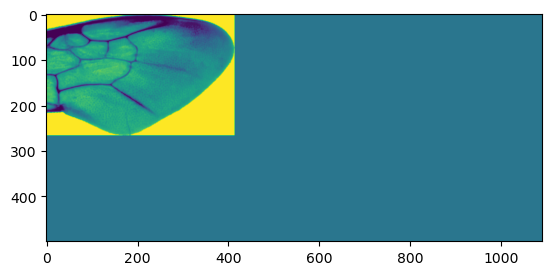

In [46]:
import cv2
nda = sitk.GetArrayFromImage(simg2)
plt.imshow(nda)

In [44]:
im = cv2.imread('../2_live_bees/type_seg_Hive01_Sheet_01_slide17_left.png')
cv2.imwrite('../2_live_bees/type_seg_crop_Hive01_Sheet_01_slide17_left.png',im[:,370:])

True

Initial Parameters:
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

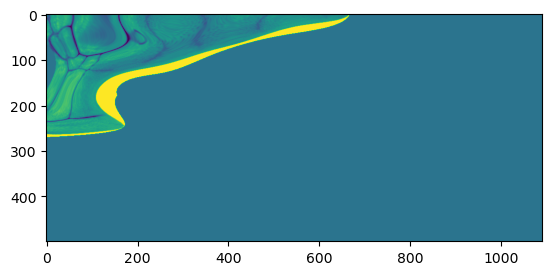

In [52]:

def command_iteration(method):
    """ Callback invoked when the optimization has an iteration """
    print(f"{method.GetOptimizerIteration():3} " + f"= {method.GetMetricValue():10.5f}")

fixed = sitk.ReadImage(fixed_fp, sitk.sitkFloat32)

moving = sitk.ReadImage(moving_fp, sitk.sitkFloat32)

transformDomainMeshSize = [8] * moving.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed, transformDomainMeshSize)

print("Initial Parameters:")
print(tx.GetParameters())

R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()

R.SetOptimizerAsLBFGSB(
    gradientConvergenceTolerance=1e-5,
    numberOfIterations=100,
    maximumNumberOfCorrections=5,
    maximumNumberOfFunctionEvaluations=1000,
    costFunctionConvergenceFactor=1e7,
)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, out_fp)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)
nda = sitk.GetArrayFromImage(simg2)
plt.imshow(nda)


In [71]:
def command_iteration(method):
    """ Callback invoked when the optimization has an iteration """
    if method.GetOptimizerIteration() == 0:
        print("Estimated Scales: ", method.GetOptimizerScales())
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():7.5f} "
        + f": {method.GetOptimizerPosition()}"
    )


def main(args):
    """ A SimpleITK example demonstrating image registration using the
        correlation metric and the center of mass initial transformation
        estimation method. """
    if len(args) < 3:
        print(
            "Usage:",
            "ImageRegistrationMethod3"
            "<fixedImageFilter> <movingImageFile>  <outputTransformFile>",
        )
        sys.exit(1)

fixed = sitk.ReadImage(fixed_fp, sitk.sitkFloat32)

moving = sitk.ReadImage(moving_fp, sitk.sitkFloat32)

R = sitk.ImageRegistrationMethod()

R.SetMetricAsCorrelation()

R.SetOptimizerAsRegularStepGradientDescent(
    learningRate=2.0,
    minStep=1e-4,
    numberOfIterations=500,
    gradientMagnitudeTolerance=1e-8,
)
R.SetOptimizerScalesFromIndexShift()

tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Similarity2DTransform())
R.SetInitialTransform(tx)

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, out_fp)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)


TypeError: Similarity2DTransform.__init__() got an unexpected keyword argument 'scaleFactor'

Estimated Scales:  (383037.51206939196, 383034.3201007543, 0.999999999998181, 0.999999999998181)
  0 = -0.00355 : (1.000607856270915, 0.00022429584215893675, -313.9698371461413, -114.79338506340967)
  1 = -0.00729 : (1.0012011878683422, 0.0005003832619139647, -313.92148813038744, -116.79280046407283)
  2 = -0.01219 : (1.0017584834543092, 0.0008641010884353837, -313.90227525468447, -118.7927080675731)
  3 = -0.01678 : (1.0022463134803568, 0.0013976387146964059, -313.93815876608704, -120.79238600438416)
  4 = -0.02080 : (1.00266769390828, 0.0021802393062507986, -314.05651069094154, -122.78888094098131)
  5 = -0.02408 : (1.0030118410890412, 0.0031680612706697503, -314.1989544401205, -124.78380166223576)
  6 = -0.02618 : (1.0028043923693504, 0.00478180742521088, -314.07944599925565, -126.7802272394488)
  7 = -0.02751 : (1.001540010563373, 0.007461583990813746, -313.49763351103616, -128.6937280752699)
  8 = -0.02957 : (1.001117882365068, 0.009387501841318015, -313.31638162409837, -130.68549

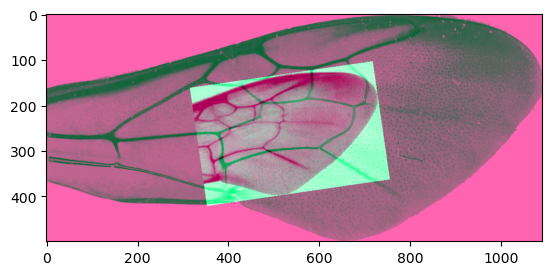

In [67]:
nda = sitk.GetArrayFromImage(cimg)
plt.imshow(nda)

In [60]:
def command_iteration(method):
    """ Callback invoked when the optimization has an iteration. """
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )




fixed = sitk.ReadImage(fixed_fp, sitk.sitkFloat32)
moving = sitk.ReadImage(moving_fp, sitk.sitkFloat32)

numberOfBins = 24
samplingPercentage = 0.10

R = sitk.ImageRegistrationMethod()
R.SetMetricAsMattesMutualInformation(numberOfBins)
R.SetMetricSamplingPercentage(samplingPercentage, sitk.sitkWallClock)
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetOptimizerAsRegularStepGradientDescent(1.0, 0.001, 200)
R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

sitk.WriteTransform(outTx, out_fp)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)

  0 =   -0.17063 : (-0.06180368078090239, 0.9980883252708311)
  1 =   -0.17867 : (-0.9251925938467027, 1.5026273077043548)
  2 =   -0.18131 : (-0.43473806542723964, 2.3740940916685185)
  3 =   -0.18817 : (-1.0237189991782474, 3.1822410211793537)
  4 =   -0.19375 : (-1.7814928299195318, 3.834758317075546)
  5 =   -0.19986 : (-1.9990517260626057, 4.810805511994422)
  6 =   -0.20683 : (-2.42112996661354, 4.542757085672931)
  7 =   -0.20409 : (-2.352773830904944, 4.783230449501418)
  8 =   -0.20659 : (-2.5741669104882305, 4.899355831363561)
  9 =   -0.20627 : (-2.8162000845894744, 4.836746386113847)
 10 =   -0.20567 : (-2.7963789683729297, 4.9601648748095455)
 11 =   -0.20649 : (-2.858790916050778, 4.963481316736907)
 12 =   -0.20655 : (-2.920435171117485, 4.9531742406592425)
 13 =   -0.20665 : (-2.8969019232858564, 4.973735095371417)
 14 =   -0.20644 : (-2.8971208021596175, 4.958111628501396)
 15 =   -0.20642 : (-2.892809809011213, 4.964627032888264)
-------
itk::simple::TranslationTransf

In [77]:
from pystackreg import StackReg
from skimage import io

#load reference and "moved" image
ref = io.imread(fixed_fp)[:,:,0]
mov = io.imread(moving_fp)[:,:,0]



#Affine transformation
sr = StackReg(StackReg.AFFINE)
out_aff = sr.register_transform(ref, mov)

ValueError: Input arrays must of the same shape

In [2]:
from glob import glob
import numpy as np
fixed_fp = np.random.choice(glob('../2_live_bees/2_card_segs_cropped_and_flipped/*'))
# Open the image files.

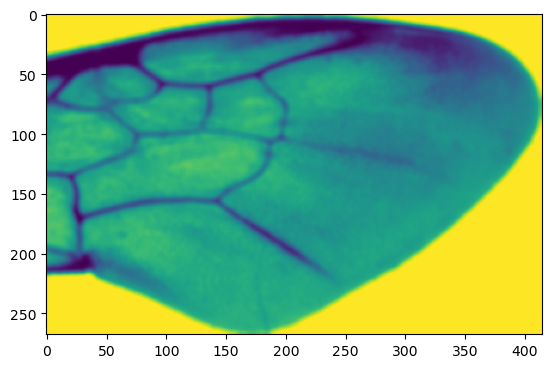

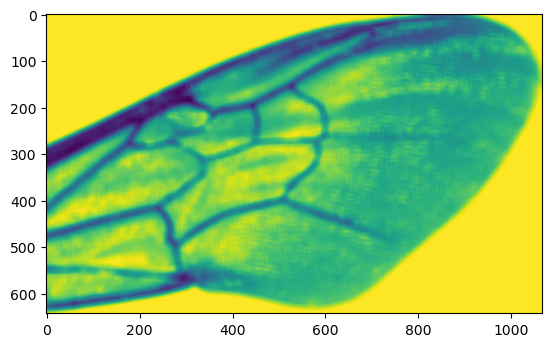

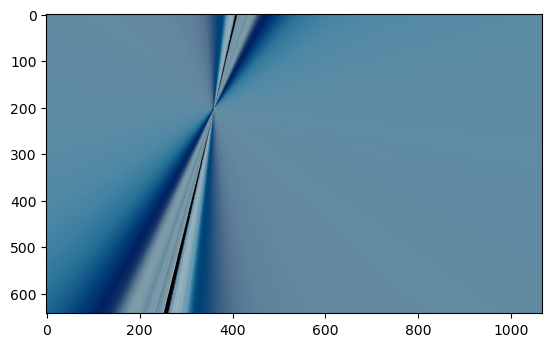

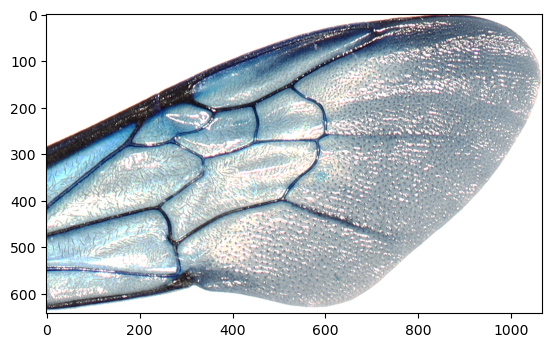

In [121]:
img1_color = cv2.imread(moving_fp)  # Image to be aligned.
img2_color = cv2.imread(fixed_fp)    # Reference image.

# Convert to grayscale.
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

img1 = cv2.blur(img1, (5,5))
img2 = cv2.blur(img2, (15,15))

plt.imshow(img1)
plt.figure()
plt.imshow(img2)
height, width = img2.shape

# Create ORB detector with 5000 features.
orb_detector = cv2.ORB_create(5000)

# Find keypoints and descriptors.
# The first arg is the image, second arg is the mask
#  (which is not required in this case).
kp1, d1 = orb_detector.detectAndCompute(img1, None)
kp2, d2 = orb_detector.detectAndCompute(img2, None)

# Match features between the two images.
# We create a Brute Force matcher with 
# Hamming distance as measurement mode.
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Match the two sets of descriptors.
matches = list(matcher.match(d1, d2))

# Sort matches on the basis of their Hamming distance.
matches.sort(key = lambda x: x.distance)

# Take the top 90 % matches forward.
matches = matches[:int(len(matches)*0.9)]
no_of_matches = len(matches)

# Define empty matrices of shape no_of_matches * 2.
p1 = np.zeros((no_of_matches, 2))
p2 = np.zeros((no_of_matches, 2))

for i in range(len(matches)):
  p1[i, :] = kp1[matches[i].queryIdx].pt
  p2[i, :] = kp2[matches[i].trainIdx].pt

# Find the homography matrix.
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

# Use this matrix to transform the
# colored image wrt the reference image.
transformed_img = cv2.warpPerspective(img1_color,
                    homography, (width, height))

# Save the output.
cv2.imwrite('output.jpg', transformed_img)
plt.figure()
plt.imshow(transformed_img)
plt.figure()
plt.imshow(cv2.imread(fixed_fp))

/tmp/ipykernel_4520/2497817536.py:33: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(ax[0, 0], img1, img2, keypoints1, keypoints2, matches12)
/tmp/ipykernel_4520/2497817536.py:38: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(


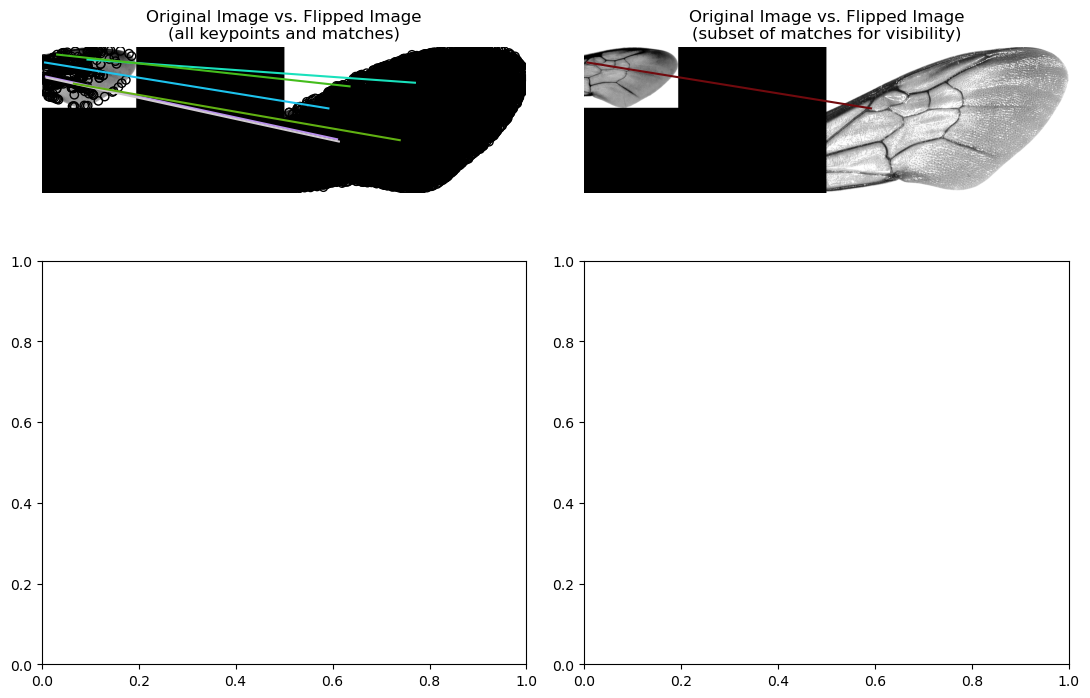

In [125]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT

img1_color = cv2.imread(moving_fp)  # Image to be aligned.
img2_color = cv2.imread(fixed_fp)    # Reference image.

# Convert to grayscale.
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)


descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(
    descriptors1, descriptors2, max_ratio=0.6, cross_check=True
)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))

plt.gray()

plot_matches(ax[0, 0], img1, img2, keypoints1, keypoints2, matches12)
ax[0, 0].axis('off')
ax[0, 0].set_title("Original Image vs. Flipped Image\n" "(all keypoints and matches)")


plot_matches(
    ax[0, 1], img1, img2, keypoints1, keypoints2, matches12[::15], only_matches=True
)
ax[0, 1].axis('off')
ax[0, 1].set_title(
    "Original Image vs. Flipped Image\n" "(subset of matches for visibility)"
)



plt.tight_layout()
plt.show()

/tmp/ipykernel_4520/99733675.py:24: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)


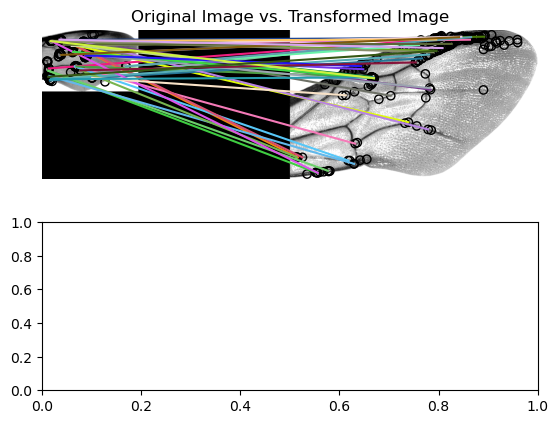

In [128]:
from skimage import data
from skimage import transform
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors



descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")



plt.show()

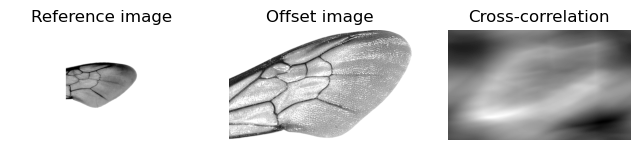

Detected pixel offset (y, x): [-78. 326.]


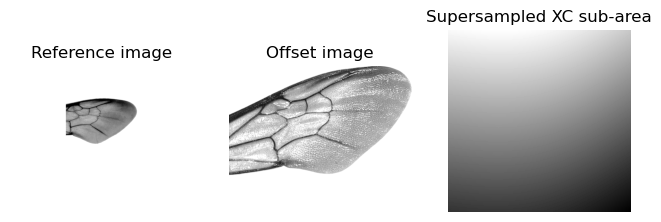

Detected subpixel offset (y, x): [-78.18 326.05]


In [145]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = big_img1
# The shift corresponds to the pixel offset relative to the reference image
offset_image = img2

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift}')

# subpixel precision
shift, error, diffphase = phase_cross_correlation(
    image, offset_image, upsample_factor=100
)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift * 100) + 75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f'Detected subpixel offset (y, x): {shift}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


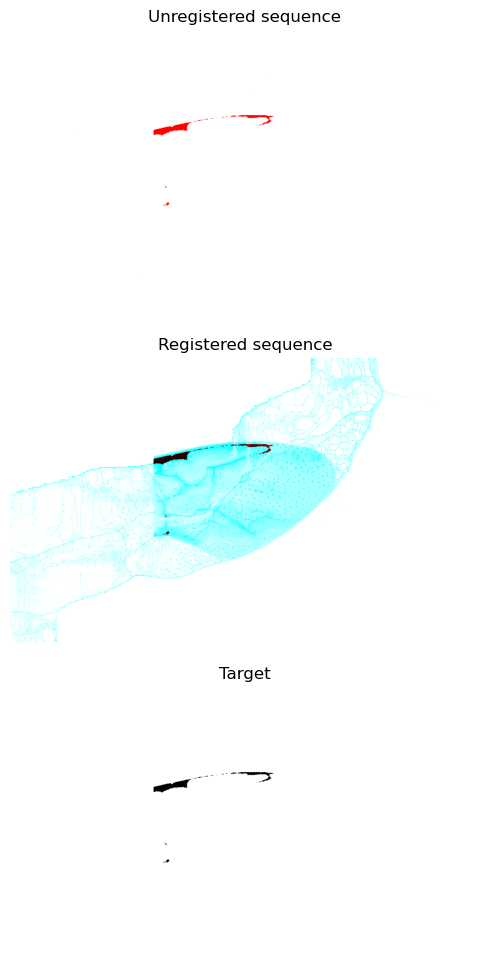

In [144]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

# --- Load the sequence
image0, image1, disp = stereo_motorcycle()

# --- Convert the images to gray level: color is not supported.
image0 = big_img1
image1 = img2

# --- Compute the optical flow
v, u = optical_flow_tvl1(image0, image1)

# --- Use the estimated optical flow for registration

nr, nc = image0.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')

image1_warp = warp(image1, np.array([row_coords + v, col_coords + u]), mode='edge')

# build an RGB image with the unregistered sequence
seq_im = np.zeros((nr, nc, 3))
seq_im[..., 0] = image1
seq_im[..., 1] = image0
seq_im[..., 2] = image0

# build an RGB image with the registered sequence
reg_im = np.zeros((nr, nc, 3))
reg_im[..., 0] = image1_warp
reg_im[..., 1] = image0
reg_im[..., 2] = image0

# build an RGB image with the registered sequence
target_im = np.zeros((nr, nc, 3))
target_im[..., 0] = image0
target_im[..., 1] = image0
target_im[..., 2] = image0

# --- Show the result

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(5, 10))

ax0.imshow(seq_im)
ax0.set_title("Unregistered sequence")
ax0.set_axis_off()

ax1.imshow(reg_im)
ax1.set_title("Registered sequence")
ax1.set_axis_off()

ax2.imshow(target_im)
ax2.set_title("Target")
ax2.set_axis_off()

fig.tight_layout()

187 188


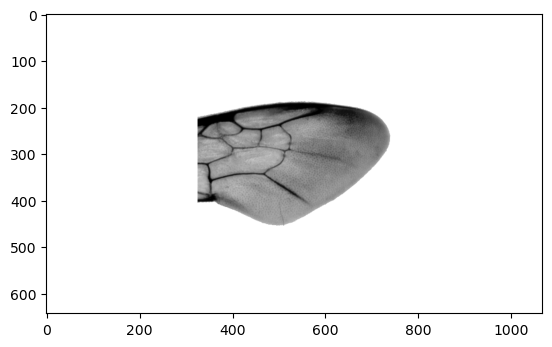

In [143]:
y = (img2.shape[0] - img1.shape[0])
by = y // 2
ay = y - by
x = (img2.shape[1] - img1.shape[1])
bx = x // 2
ax = x - bx
print(by, ay)
big_img1 = np.pad(img1, ((by,ay),(bx,ax)), constant_values=255)
plt.imshow(np.pad(img1, ((by,ay),(bx,ax)), constant_values=255))

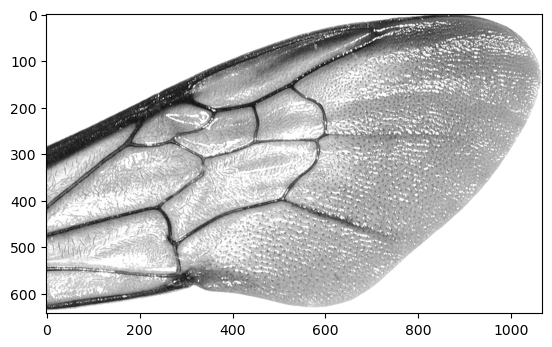

In [142]:
plt.imshow(img2)

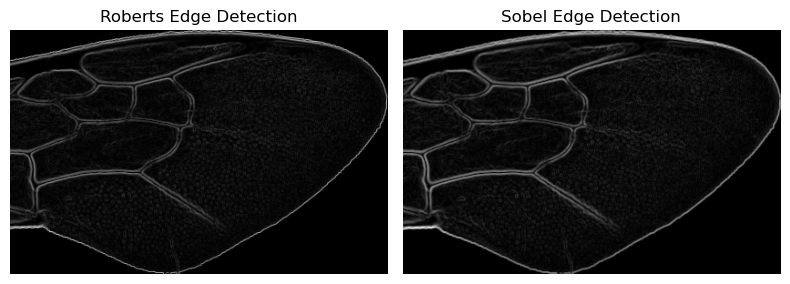

In [146]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images


image = img1
edge_roberts = filters.roberts(image)
edge_sobel = filters.sobel(image)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0].set_title('Roberts Edge Detection')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

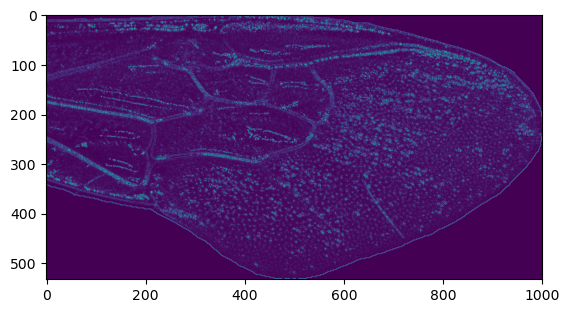

In [30]:
# Compute the Laplacian of the image
import cv2
import matplotlib.pyplot as plt
img1 = cv2.imread(fixed_fp, cv2.IMREAD_GRAYSCALE)    # Reference image.
lap = cv2.Laplacian(img1, cv2.CV_64F)
lap = np.uint8(np.absolute(lap))
plt.imshow(lap)

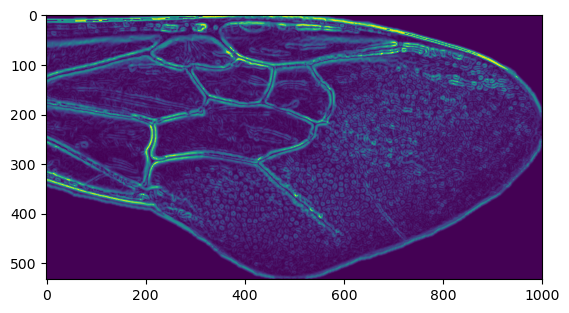

In [47]:
image = cv2.GaussianBlur(img1, (11, 11), 0)
sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)
plt.imshow( sobelCombined)

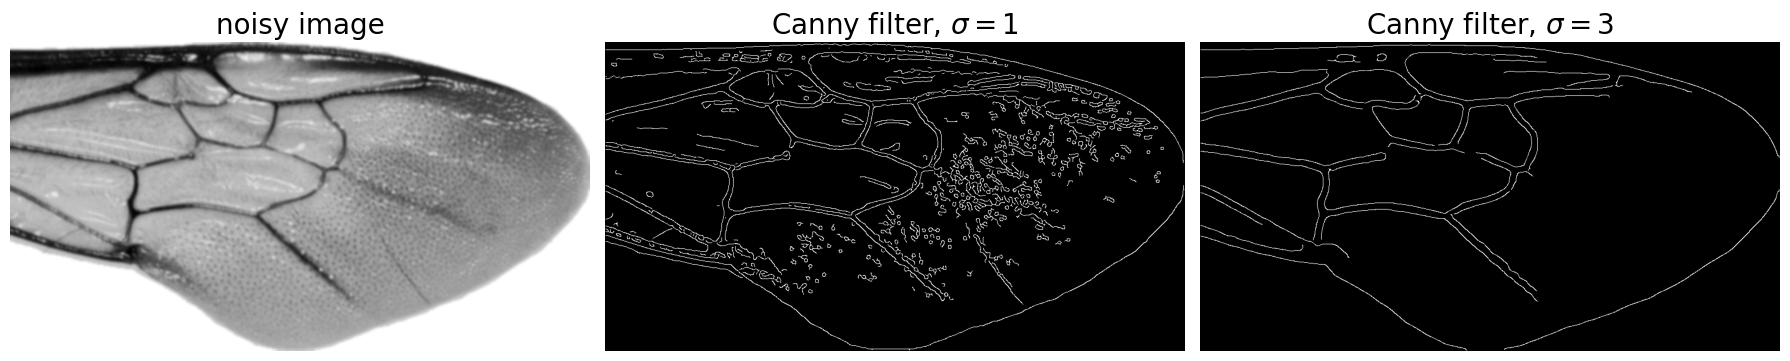

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature
# Compute the Canny filter for two values of sigma
edges1 = feature.canny(image)
edges2 = feature.canny(image, sigma=4)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

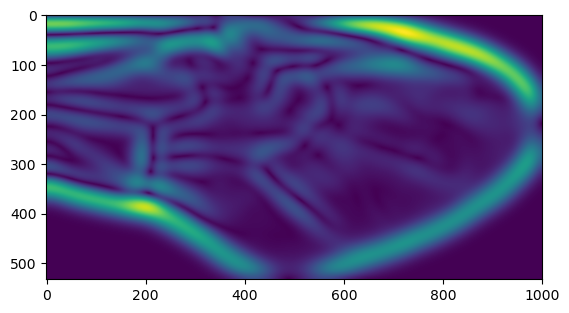

In [82]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images
from scipy import ndimage
plt.imshow((ndimage.gaussian_gradient_magnitude(img1.astype('float'), 20)))

In [73]:
ndimage.gaussian_gradient_magnitude(img1, 7).max()

15